In [1]:
import sys
print(sys.executable)


C:\Users\visha\LaTeX-OCR\venv\Scripts\python.exe


In [2]:
%pip install pytesseract pillow opencv-python pdf2image

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Core OCR imports
import pytesseract
from pix2tex.cli import LatexOCR
from PIL import Image
import cv2
import numpy as np

# For PDF conversion
from pdf2image import convert_from_path

print("✅ All imports successful!")


C:\Users\visha\LaTeX-OCR\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\visha\LaTeX-OCR\venv\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\visha\LaTeX-OCR\venv\Lib\site-packages\pydantic\_internal\_serializers.py:44: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [input_value=UniformParams(noise_type=... 0.058823529411764705)]), input_type=UniformParams])
  v = handler(item, index)
C:\Users\visha\LaTeX-OCR\venv\Lib\site-packages\pydantic\main.

✅ All imports successful!


In [5]:
%pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 9.1 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/8.1 MB 8.6 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 9.3 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.2 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 5.1 MB/s eta 0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- ------------

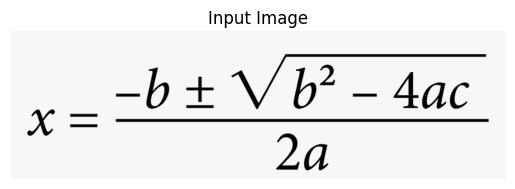

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Load your test image
image_path = r"C:\Users\visha\Downloads\test.png"  # Or replace with your own image filename
img = Image.open(image_path)

# Show the image
plt.imshow(img)
plt.axis("off")
plt.title("Input Image")
plt.show()


In [8]:
import pytesseract
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def detect_math_boxes_pytesseract(image, symbol_threshold=0.4):
    """
    Heuristically detect bounding boxes likely to be equations or math expressions.

    Args:
        image: PIL.Image
        symbol_threshold: Fraction of non-alpha chars to consider as math.

    Returns:
        List of (x1, y1, x2, y2) tuples
    """
    # Convert to grayscale for Tesseract
    gray = image.convert("L")

    # Tesseract data dict
    data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
    boxes = []

    for i in range(len(data["text"])):
        word = data["text"][i].strip()
        if not word:
            continue
        non_alpha = sum(not c.isalpha() for c in word)
        frac_non_alpha = non_alpha / len(word)
        if frac_non_alpha >= symbol_threshold:
            x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
            boxes.append((x, y, x + w, y + h))
    return boxes

# Detect math boxes
math_boxes = detect_math_boxes_pytesseract(img)
print(f"Detected {len(math_boxes)} possible math regions.")


Detected 4 possible math regions.


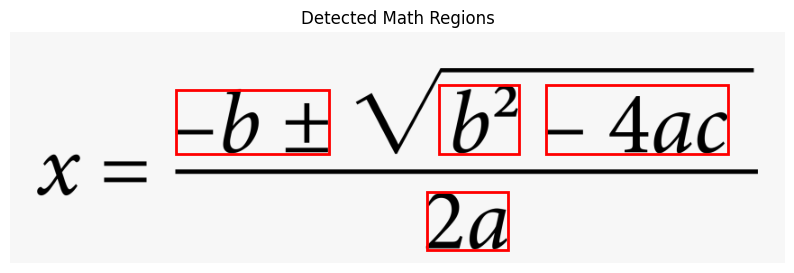

In [9]:
import matplotlib.pyplot as plt

def show_math_boxes(image, boxes):
    """
    Draw detected math boxes on the image.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)
    ax.set_title("Detected Math Regions")
    plt.axis("off")
    plt.show()

# Show the boxes
show_math_boxes(img, math_boxes)


In [10]:
from pix2tex.cli import LatexOCR

ocr = LatexOCR()

# Recognize LaTeX from the entire image
latex_code = ocr(img)

print("Recognized LaTeX code:")
print(latex_code)


Recognized LaTeX code:
x={\cfrac{-b\pm{\sqrt{b^{2}-4a c\ }}}{2a}}


In [11]:
def detect_and_merge_math_boxes(image, symbol_threshold=0.2, y_thresh=20, x_thresh=50):
    """
    Detect and merge bounding boxes likely to be equations or math expressions.
    """
    # Convert to grayscale
    gray = image.convert("L")

    # Get word boxes from Tesseract
    data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
    raw_boxes = []

    for i in range(len(data["text"])):
        word = data["text"][i].strip()
        if not word:
            continue

        non_alpha = sum(not c.isalpha() for c in word)
        frac_non_alpha = non_alpha / len(word)
        if frac_non_alpha >= symbol_threshold:
            x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
            raw_boxes.append([x, y, x + w, y + h])

    # Merge overlapping or nearby boxes into bigger regions
    merged_boxes = []
    for box in sorted(raw_boxes, key=lambda b: (b[1], b[0])):
        added = False
        for m in merged_boxes:
            if (
                abs(box[1] - m[1]) <= y_thresh and
                (box[0] <= m[2] + x_thresh and box[2] >= m[0] - x_thresh)
            ):
                # Merge this box into m
                m[0] = min(m[0], box[0])
                m[1] = min(m[1], box[1])
                m[2] = max(m[2], box[2])
                m[3] = max(m[3], box[3])
                added = True
                break
        if not added:
            merged_boxes.append(box)

    return merged_boxes

# Run the improved detection
improved_math_boxes = detect_and_merge_math_boxes(img)

print(f"Detected {len(improved_math_boxes)} merged math regions.")


Detected 3 merged math regions.


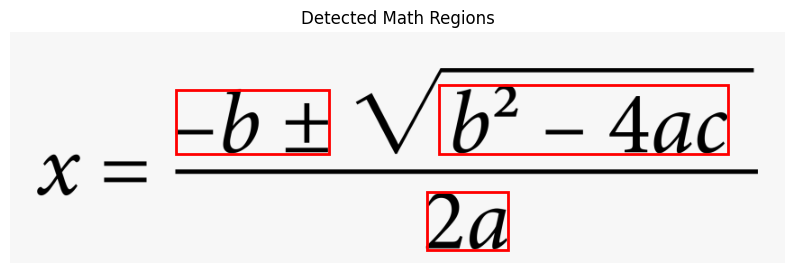

In [12]:
show_math_boxes(img, improved_math_boxes)

In [13]:
from PIL import Image

# Initialize Pix2Tex once
ocr = LatexOCR()

# For each detected region, crop and OCR
for idx, (x1, y1, x2, y2) in enumerate(improved_math_boxes):
    cropped = img.crop((x1, y1, x2, y2))
    latex = ocr(cropped)
    print(f"\nRegion {idx+1} LaTeX:")
    print(latex)



Region 1 LaTeX:
b^{2}-4a c

Region 2 LaTeX:
-\partial\Omega

Region 3 LaTeX:
{\mathcal{D}}_{}^{}


In [14]:
from pdf2image import convert_from_path

# Path to your PDF file
pdf_path = r"C:\Users\visha\Downloads\lemh201.pdf"

# Output folder
output_dir = r"C:\Users\visha\Downloads\integral_pages"

import os
os.makedirs(output_dir, exist_ok=True)

# Convert all pages (you can change 'first_page' and 'last_page' to limit)
images = convert_from_path(pdf_path, dpi=300)

# Save images
for i, img in enumerate(images):
    img_path = os.path.join(output_dir, f"page_{i+1:03}.png")
    img.save(img_path)
    print(f"Saved: {img_path}")

print("✅ All pages converted.")


Saved: C:\Users\visha\Downloads\integral_pages\page_001.png
Saved: C:\Users\visha\Downloads\integral_pages\page_002.png
Saved: C:\Users\visha\Downloads\integral_pages\page_003.png
Saved: C:\Users\visha\Downloads\integral_pages\page_004.png
Saved: C:\Users\visha\Downloads\integral_pages\page_005.png
Saved: C:\Users\visha\Downloads\integral_pages\page_006.png
Saved: C:\Users\visha\Downloads\integral_pages\page_007.png
Saved: C:\Users\visha\Downloads\integral_pages\page_008.png
Saved: C:\Users\visha\Downloads\integral_pages\page_009.png
Saved: C:\Users\visha\Downloads\integral_pages\page_010.png
Saved: C:\Users\visha\Downloads\integral_pages\page_011.png
Saved: C:\Users\visha\Downloads\integral_pages\page_012.png
Saved: C:\Users\visha\Downloads\integral_pages\page_013.png
Saved: C:\Users\visha\Downloads\integral_pages\page_014.png
Saved: C:\Users\visha\Downloads\integral_pages\page_015.png
Saved: C:\Users\visha\Downloads\integral_pages\page_016.png
Saved: C:\Users\visha\Downloads\integral